In [51]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from copy import copy
from torch.utils.data import WeightedRandomSampler

In [49]:
transform1 = transforms.Compose([
    transforms.Resize([300, 300]),
    transforms.ToTensor() 
])

sea_dataset = datasets.ImageFolder(root='sea_animals', transform=transform1)

train_dataset, test_dataset = random_split(sea_dataset, [0.8, 0.2])

# считаем mean и std на train 
loader = DataLoader(train_dataset, batch_size=len(sea_dataset))
data = next(iter(loader))
mean = data[0].mean(dim=(0, 2, 3))
std = data[0].std(dim=(0, 2, 3))

train_dataset.dataset = copy(train_dataset.dataset)

transform2 = transforms.Compose([
      transforms.Resize([300, 300]),
      transforms.Normalize(mean, std),
      transforms.ToTensor()
])

train_dataset.dataset.transform = transform2

In [40]:
num_images = len(sea_dataset)
print(f"всего картинок: {num_images}")

sample_image, _ = sea_dataset[0]  
image_size = sample_image.size()
print(f"размер картинок: {image_size}")

num_classes = len(sea_dataset.classes)
print(f"количество классов: {num_classes}")


train_size = int(0.8 * num_images)
test_size = num_images - train_size
train_dataset, test_dataset = torch.utils.data.random_split(sea_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=50)
test_loader = DataLoader(test_dataset, batch_size=50)

print(f"train_size: {len(train_dataset)}")
print(f"test_size: {len(test_dataset)}")

всего картинок: 2306
размер картинок: torch.Size([3, 300, 300])
количество классов: 6
train_size: 1844
test_size: 462


In [41]:
train_class_counts = {class_label: 0 for class_label in sea_dataset.classes}
for _, target in train_dataset:
    train_class_counts[sea_dataset.classes[target]] += 1

test_class_counts = {class_label: 0 for class_label in sea_dataset.classes}
for _, target in test_dataset:
    test_class_counts[sea_dataset.classes[target]] += 1

print("Доли Train:")
for class_label, count in train_class_counts.items():
    class_fraction = count / train_size
    print(f"{class_label}: {class_fraction:.4f}")

print("\nДоли Test:")
for class_label, count in test_class_counts.items():
    class_fraction = count / test_size
    print(f"{class_label}: {class_fraction:.4f}")

Доли Train:
Dolphin: 0.1730
Sea Rays: 0.1047
Sea Urchins: 0.0759
Seahorse: 0.1063
Sharks: 0.1334
Turtle_Tortoise: 0.4067

Доли Test:
Dolphin: 0.1558
Sea Rays: 0.1407
Sea Urchins: 0.0693
Seahorse: 0.0931
Sharks: 0.1061
Turtle_Tortoise: 0.4351


In [42]:
lr = 0.0001
epochs = 10

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flat = nn.Flatten(start_dim=1)
        self.fc = nn.Linear(5 * 149 * 149, 6)

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        out = self.pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses_list = []
train_accuracies_list = []
test_accuracies_list = []

for epoch in tqdm(range(epochs)):

    # train
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    train_predictions_list = []
    train_labels_list = []
    test_predictions_list = []
    test_labels_list = []

    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)

        train_predictions_list.extend(predicted)
        train_labels_list.extend(labels)

    train_accuracy = accuracy_score(train_labels_list, train_predictions_list) 
    train_losses_list.append(train_loss)
    train_accuracies_list.append(train_accuracy)

    # evaluate
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            test_predictions_list.extend(predicted)
            test_labels_list.extend(labels)

    test_accuracy = accuracy_score(test_labels_list, test_predictions_list) 
    test_accuracies_list.append(test_accuracy)

print(f"Final train accuracy = {train_accuracies_list[-1]}")
print(f"Final test accuracy = {test_accuracies_list[-1]}")

100%|██████████| 10/10 [01:59<00:00, 11.99s/it]

Final train accuracy = 0.7098698481561823
Final test accuracy = 0.577922077922078


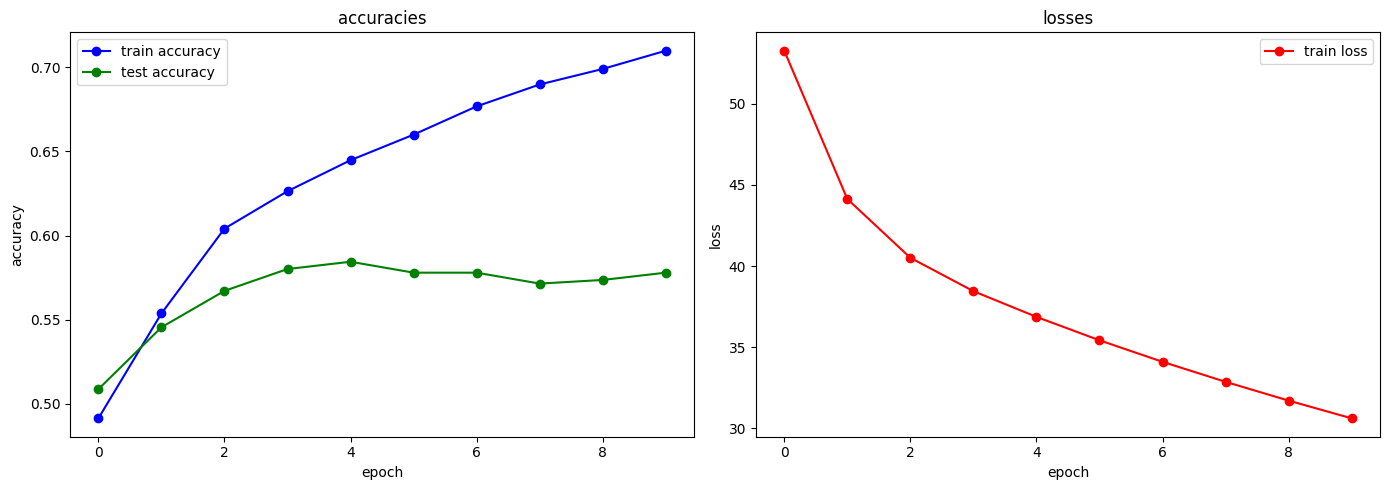

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(train_accuracies_list, label='train accuracy', marker='o', color='b')
axs[0].plot(test_accuracies_list, label='test accuracy', marker='o', color='g')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('accuracy')
axs[0].set_title('accuracies')
axs[0].legend()

axs[1].plot(train_losses_list, label='train loss', marker='o', color='r')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('losses')
axs[1].legend()

plt.tight_layout()
plt.show()

In [44]:
# train
class_report = classification_report(train_labels_list, train_predictions_list)
print(class_report)

              precision    recall  f1-score   support

           0       0.68      0.75      0.71       319
           1       0.61      0.38      0.47       193
           2       0.85      0.56      0.67       140
           3       0.71      0.41      0.52       196
           4       0.65      0.62      0.63       246
           5       0.74      0.92      0.82       750

    accuracy                           0.71      1844
   macro avg       0.71      0.60      0.64      1844
weighted avg       0.71      0.71      0.69      1844



In [45]:
# test
class_report = classification_report(test_labels_list, test_predictions_list)
print(class_report)

              precision    recall  f1-score   support

           0       0.47      0.78      0.59        72
           1       0.25      0.08      0.12        65
           2       0.79      0.34      0.48        32
           3       0.35      0.21      0.26        43
           4       0.38      0.33      0.35        49
           5       0.70      0.85      0.77       201

    accuracy                           0.58       462
   macro avg       0.49      0.43      0.43       462
weighted avg       0.54      0.58      0.54       462



In [46]:
# train
conf_matrix = confusion_matrix(train_labels_list, train_predictions_list)
print(conf_matrix)

[[238  12   0   4  29  36]
 [ 32  73   0   9  31  48]
 [  0   2  78   3   0  57]
 [ 13   4   5  81  12  81]
 [ 46  20   0   4 152  24]
 [ 23   8   9  13  10 687]]


In [47]:
# test
conf_matrix = confusion_matrix(test_labels_list, test_predictions_list)
print(conf_matrix)

[[ 56   6   0   1   5   4]
 [ 29   5   0   3  15  13]
 [  1   0  11   1   0  19]
 [  3   1   1   9   1  28]
 [ 16   6   0   3  16   8]
 [ 13   2   2   9   5 170]]


# WeightedRandomSampler

In [106]:
transform1 = transforms.Compose([
    transforms.Resize([300, 300]),
    transforms.ToTensor() 
])

sea_dataset = datasets.ImageFolder(root='sea_animals', transform=transform1)

train_dataset, test_dataset = random_split(sea_dataset, [0.8, 0.2])

# считаем mean и std на train 
loader = DataLoader(train_dataset, batch_size=len(sea_dataset))
data = next(iter(loader))
mean = data[0].mean(dim=(0, 2, 3))
std = data[0].std(dim=(0, 2, 3))

train_dataset.dataset = copy(train_dataset.dataset)

transform2 = transforms.Compose([
      transforms.Resize([300, 300]),
      transforms.Normalize(mean, std),
      transforms.ToTensor()
])

train_dataset.dataset.transform = transform2

In [100]:
train_size = int(0.8 * num_images)
test_size = num_images - train_size
train_dataset, test_dataset = random_split(sea_dataset, [train_size, test_size])

class_to_index = sea_dataset.class_to_idx

train_class_counts = {idx: 0 for idx in range(len(sea_dataset.classes))}

for _, target in train_dataset:
    class_idx = class_to_index[sea_dataset.classes[target]]
    train_class_counts[class_idx] += 1


train_labels = [item[1] for item in train_dataset.dataset]
weights = [1 / train_class_counts[class_label] for class_label in train_labels]

sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_dataset), replacement=True)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=50)
test_loader = DataLoader(test_dataset, batch_size=50)

In [ ]:
lr = 0.0001
epochs = 10

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flat = nn.Flatten(start_dim=1)
        self.fc = nn.Linear(5 * 149 * 149, 6)

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        out = self.pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses_list = []
train_accuracies_list = []
test_accuracies_list = []

for epoch in tqdm(range(epochs)):

    # train
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    train_predictions_list = []
    train_labels_list = []
    test_predictions_list = []
    test_labels_list = []

    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)

        train_predictions_list.extend(predicted)
        train_labels_list.extend(labels)

    train_accuracy = accuracy_score(train_labels_list, train_predictions_list) 
    train_losses_list.append(train_loss)
    train_accuracies_list.append(train_accuracy)

    # evaluate
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            test_predictions_list.extend(predicted)
            test_labels_list.extend(labels)

    test_accuracy = accuracy_score(test_labels_list, test_predictions_list) 
    test_accuracies_list.append(test_accuracy)

print(f"Final train accuracy = {train_accuracies_list[-1]}")
print(f"Final test accuracy = {test_accuracies_list[-1]}")